# Modeltraining

In [192]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [193]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer, QuantileTransformer

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import scipy.stats as stats

from sklearn.decomposition import PCA

from sklearn.inspection import permutation_importance

from sklearn import set_config
#set_config(transform_output="pandas")

In [194]:
# get main, clean prepared df 
from model_pipeline import data_preparation
df = data_preparation()

### Helper Visualization Functions

In [195]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [196]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals)
    
    plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    ax.set_xlim(-15, y_true.max())
    ax.set_ylim(-15, y_true.max())
    
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

# Q-Q Plot
def prob_plot(residuals):
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, plot=plt)
    plt.show()

In [197]:
# -----------------------------------
# METRIC SCORES FOR CV
#------------------------------------
def show_scores(grid, model):
    best_score = grid.best_score_ 
    best_idx = grid.best_index_
    cv_res = pd.DataFrame(grid.cv_results_)

    best_estimator = pd.DataFrame(cv_res.loc[cv_res["mean_test_r2"] == best_score]).reset_index()
    
    print(f"\n------{model} CV SCORES--------")  
    print("\nR2:")
    print(f'''\nTrain Folds R2 Scores: {[round(cv_res[f"split{i}_train_r2"][best_idx], 2) for i in range(8)]}
            \nMean Train R2 Score: {round(cv_res["mean_train_r2"][best_idx], 2)}
            \nTest Folds R2 Scores: {[round(cv_res[f"split{i}_test_r2"][best_idx], 2) for i in range(8)]}
            \nMean Test R2 Score (best_score_): {round(cv_res["mean_test_r2"][best_idx], 2)}''')   
    print("\nMAE:")
    #print(f'MAE error in relation to mean target: {-round( (cv_res["mean_test_mae"][best_idx] / target_mean()) * 100, 2 )} %')
    print(f'''\nTrain Folds MAE Scores: {[-round(cv_res[f"split{i}_train_mae"][best_idx], 2) for i in range(8)]}
            \nMean Train MAE Score: {-round(cv_res["mean_train_mae"][best_idx],2)}
            \nTest Folds MAE Scores: {[-round(cv_res[f"split{i}_test_mae"][best_idx], 2) for i in range(8)]}
            \nMean Test MAE Score: {-round(cv_res["mean_test_mae"][best_idx],2)}
            \nStd Test MAE Score: {round(cv_res["std_test_mae"][best_idx], 2)}''') 
    print("\nRMSE:")
    print(f'''\nTrain Folds RMSE Scores: {[-round(cv_res[f"split{i}_train_rmse"][best_idx], 2) for i in range(8)]}
            \nMean Train RMSE Score: {-round(cv_res["mean_train_rmse"][best_idx], 2)}
            \nTest Folds RMSE Scores: {[-round(cv_res[f"split{i}_test_rmse"][best_idx], 2) for i in range(8)]}
            \nMean Test RMSE Score: {-round(cv_res["mean_test_rmse"][best_idx], 2)}
            \nStd Test MAE Score: {round(cv_res["std_test_rmse"][best_idx], 2)}''')
    print("-----------------------------------------\n")

metrics = {"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}

### Variables & Train-Test Split

In [326]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"] #target
X = df.drop(columns=["Code", "Year", "child_mortality_igme"]) #features
group = df["Entity"]

num_variables = X.drop(columns=["Entity", "world_regions_wb", "world_income_group"]).columns.to_list()
cat_variables = ["world_regions_wb", "world_income_group"]
regions_list = sorted(X["world_regions_wb"].dropna().unique())
incomegroups_list = sorted(X["world_income_group"].dropna().unique())

normal = ["years_of_schooling", "share_of_population_urban"]
others = ["vaccination_coverage_who_unicef"] #["years_of_schooling", "share_of_population_urban", "vaccination_coverage_who_unicef"] #leftskewed or normal-skewed vars
remove_nonskewed = normal + others

skewed_variables = num_variables.copy() #rightskewed vars
for el in remove_nonskewed:
    if el in skewed_variables:
        skewed_variables.remove(el)

world_regions = ["world_regions_wb"]
income_groups = ["world_income_group"]

#helper column names
col_country = "Entity"             
col_regions = "world_regions_wb"  
col_incomegroup = "world_income_group"
all_numeric_cols = skewed_variables + others + normal

all_numeric_cols

['annual_healthcare_expenditure_per_capita',
 'gdp_per_capita_worldbank',
 'nurses_and_midwives_per_1000_people',
 'physicians_per_1000_people',
 'prevalence_of_undernourishment',
 'share_without_improved_water',
 'vaccination_coverage_who_unicef',
 'years_of_schooling',
 'share_of_population_urban']

In [327]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

### Kmeans Cluster

In [328]:
# -------------------------------------
# KMeans Cluster outside of Pipeline
#--------------------------------------

X_train_cluster = X_train[num_variables].copy()

kmeans_rscaler = RobustScaler()
X_kmeans_scaled = kmeans_rscaler.fit_transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=6, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
X_cl_train = X_train.copy()
X_cl_train[km_distcols] = km_dist_train

clusters_df = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.index)
#kmeans_cluster_columns = pd.concat([km_dist_train], axis=1)
#kmeans_cluster_cols = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.copy().index)

In [329]:
#Kmeans on Testset
X_holdout_testset = X_test[num_variables].copy()

X_test_df = X_holdout_testset.copy()
X_test_df_scaled = kmeans_rscaler.transform(X_test_df)  
X_test_df_imputed = knn_impute.transform(X_test_df_scaled)  
km_dist_test = km_train.transform(X_test_df_imputed)

km_test_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_test.shape[1])]
X_cl_test = X_test.copy()
X_cl_test[km_test_distcols] = km_dist_test

#### Extreme Outliers vs Normal

In [205]:
q95 = np.quantile(y_train, 0.95)

norm_mask = y_train <= q95
extrem_mask = y_train > q95

X_train_norm = X_cl_train[norm_mask]
y_train_norm = y_train[norm_mask]
groups_train_norm = group_train[norm_mask]  

X_train_extrem = X_cl_train[extrem_mask]
y_train_extrem = y_train[extrem_mask]
groups_train_extrem = group_train[extrem_mask]  

#### Visualize Cluster with PCA

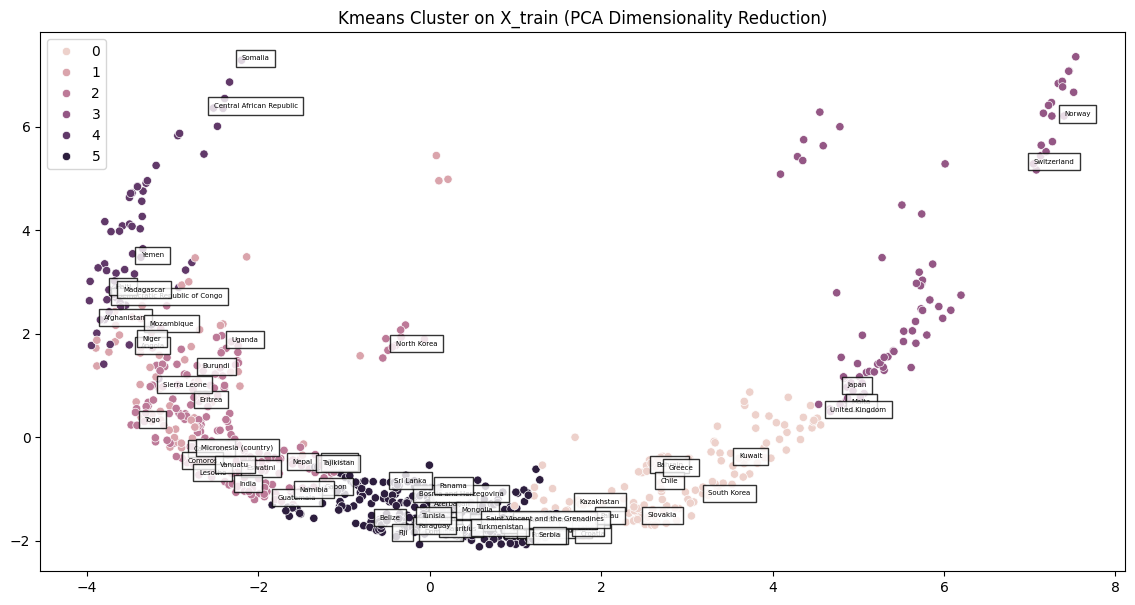

In [330]:
# ----------------------------------
# Visualize Cluster (PCA)
#-----------------------------------
df_imputed = pd.DataFrame(
    X_kmeans_imputed,
    columns=X_cl_train[num_variables].columns,  
    index=X_cl_train[num_variables].index      
)

X_cluster_pca = pd.concat([df_imputed, clusters_df], axis=1)
X_cluster_pca["Entity"] = X_cl_train["Entity"]
X_cluster_dist = X_cluster_pca[["kmeans_dist_0", "kmeans_dist_1", "kmeans_dist_2", "kmeans_dist_3", "kmeans_dist_4", "kmeans_dist_5"]]

clusters = X_cluster_dist.values.argmin(axis=1)

X_2d = PCA(n_components=2).fit_transform(X_cluster_dist)
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters)

n=14
for i, c in enumerate(X_cluster_pca["Entity"]):
    if i % n == 0:
        plt.text(X_2d[i, 0], X_2d[i, 1], c, fontsize=5, bbox=dict(facecolor="white", alpha=0.8))
plt.title("Kmeans Cluster on X_train (PCA Dimensionality Reduction)")
plt.show()

### Within Information - Realtive to Countries Mean

In [331]:
# ----------------------------------
# CustomTransfomer: 
# create new within country columns
# relative to mean: (num_col value) - (mean num_col value per country)
#-----------------------------------
class RelativeToCountryMean(BaseEstimator, TransformerMixin):
    def __init__(self, country_col, num_cols):
        self.country_col = country_col
        self.num_cols = num_cols
        #self.order_name = f"{num_cols}_order"
        
    def fit(self, X, y=None):
        self.means_ = X.groupby(self.country_col)[self.num_cols].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_cols:
            X[f"{col}_rel_to_mean"] = X[self.country_col].map(self.means_[col])
            #X[col] = X[self.country_col].map(self.means_[col])
            X[f"{col}_order"] = X.groupby(self.country_col)[col].rank(method="average", pct=True)
            #X[col] = X[col].fillna(X[col].mean())
            #print(X[col].isna().sum())
        return X

### Preprocessing Pipeline

In [332]:
# ----------------------------------
# Preprocessing Pipeline Steps
#-----------------------------------

#impute & transform numeric columns
impute_transform = ColumnTransformer([
    ("log_nums", Pipeline([
        ("knn_impute", KNNImputer(n_neighbors=5, weights="distance")),
        ("log_transform", FunctionTransformer(np.log1p))
    ]), skewed_variables),
    
    ("powertransform_nums", Pipeline([
        ("knn_impute2", KNNImputer(n_neighbors=5, weights="distance")),
        ("powertransform", PowerTransformer(method="yeo-johnson"))
    ]), others),
    
    ("normal_dist_nums", Pipeline([
        ("knn_impute3", KNNImputer(n_neighbors=5, weights="distance")),
    ]), normal)
    
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform="pandas")

#one hot encode pipeline for categoric cols
categorical_cols = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

#Scale all num cols, ohe & drop country col
scale_ohe_step = ColumnTransformer([
    ("scale_nums", RobustScaler(), all_numeric_cols),
    ("ohe_cat", categorical_cols, [col_regions, col_incomegroup]),
    ("drop_country", "drop", [col_country])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#combine steps for model pipeline
end_pipe = Pipeline([
    ("prep_nums", impute_transform),
    #("relative_to_mean", RelativeToCountryMean(
    #    country_col=col_country, 
    #    num_cols=all_numeric_cols
    #)),
    #("transf_nums", nums_transf),
    ("scale_ohe", scale_ohe_step),
    ("final_impute", KNNImputer(n_neighbors=5, weights="distance")),
])

gk = GroupKFold(n_splits=8)

### Linear Regression (Baseline)

In [333]:
from sklearn.model_selection import cross_validate
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", LinearRegression())
])

qu_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100)
#Target is rightskewed, logtransform y before training
lr_pipeline_y_log = TransformedTargetRegressor(
    regressor=lr_pipeline,
    #transformer=qu_transformer
    func=np.log1p,
    inverse_func=np.expm1
)

lr_r2_cv = cross_val_score(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk, scoring="r2")
lr_mae_cv = cross_val_score(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_r2_score = lr_r2_cv
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv
# print crossvalidations scores (splitted into gk-folds (5), fit on gk - 1 & evaluate on last fold > iterate 5times)
print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nR2:")
print(f"\nFolds R2 scores: {lr_r2_score}\nMean R2 Score: {round(lr_r2_score.mean(), 2)}")
print("\nMAE:")
#print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {round(lr_mae_score.mean(), 2)}\nStd MAE Score: {round(lr_mae_score.std(), 2)}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {round(lr_rmse_score.mean(), 2)}\nStd RMSE Score: {round(lr_rmse_score.std(), 2)}\n")
print("-----------------------------------------\n")


lr_cv_results = cross_validate(
    estimator=lr_pipeline_y_log,
    X=X_train,
    y=y_train,
    groups=group_train,          
    cv=gk,
    scoring=metrics,
    return_train_score=True,
    return_estimator=True
)
print(f'Train r2 mean: {lr_cv_results["train_r2"].mean()}, Train mae mean: {-lr_cv_results["train_mae"].mean()}, Train rmse mean: {-lr_cv_results["train_rmse"].mean()}')


------LINEAR REGRESSION CV SCORES--------

R2:

Folds R2 scores: [0.73594858 0.78331737 0.8334683  0.60008313 0.78551782 0.69619225
 0.74832922 0.7630689 ]
Mean R2 Score: 0.74

MAE:

Folds MAE scores: [11.01093177  7.98709404  9.6455044  16.5804136  10.19994446  7.48593586
 11.21101257 10.10680569]
Mean MAE Score: 10.53
Std MAE Score: 2.6

RMSE:

Folds RMSE scores: [16.04156635 11.20640774 13.32744223 35.66508949 16.88140456 11.22879657
 17.49603064 16.51862114]
Mean RMSE Score: 17.3
Std RMSE Score: 7.33

-----------------------------------------

Train r2 mean: 0.7756616901474097, Train mae mean: 9.226119749744202, Train rmse mean: 16.882384837458616


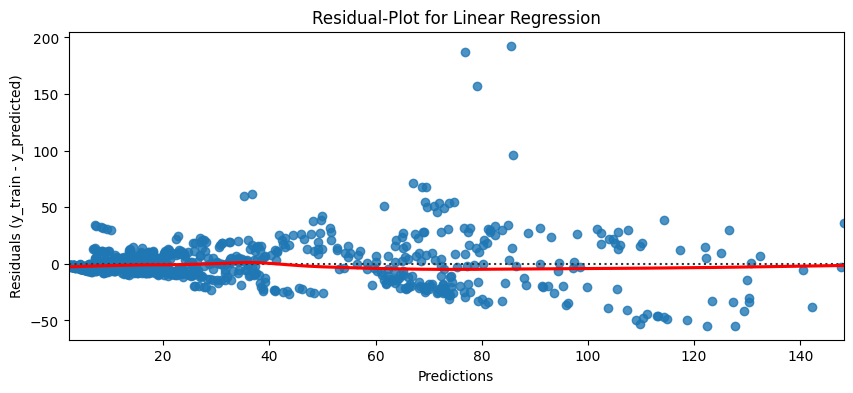

In [334]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

#lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_train_norm, y_train_norm, groups=groups_train_norm, cv=gk)
#lr_residuals = y_train_norm - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

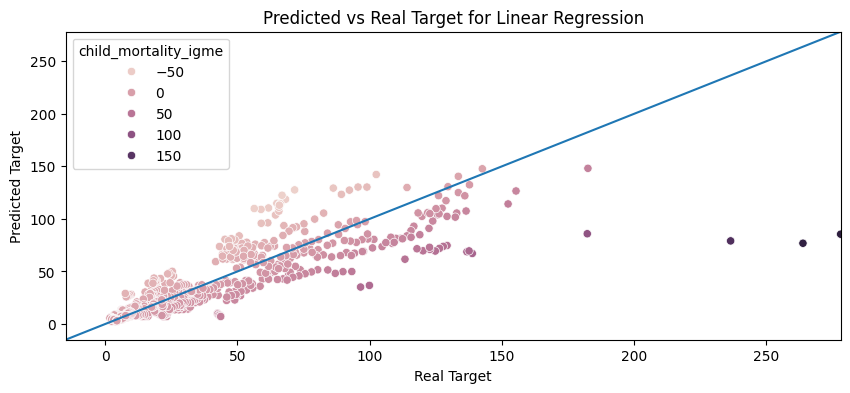

In [335]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")
#actual_vs_predicted(y_train_norm, lr_y_predicts, lr_residuals, "Linear Regression")

In [336]:
#print all feature columns
first_fitted_estimatorlr = lr_cv_results['estimator'][0]
feature_pipelinelr = first_fitted_estimatorlr.regressor_
pre_pipelinelr = feature_pipelinelr.named_steps['preprocess']
last_transformerlr = pre_pipelinelr.steps[-1][1]
feature_names_finallr = last_transformerlr.get_feature_names_out()

print(f"Feature-Namen:")
print(feature_names_finallr)

Feature-Namen:
['annual_healthcare_expenditure_per_capita' 'gdp_per_capita_worldbank'
 'nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries'
 'world_income_group_missing']


### Ridge

In [330]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL (RIDGE)
#--------------------------------------------------
ridge_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", Ridge())
])

#Target is rightskewed, logtransform y before training
ridge_pipeline_y_log  = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    #func=np.log1p,
    #inverse_func=np.expm1
    transformer=qu_transformer
)

ridge_param_grid = {
    "regressor__model__alpha": [0.1, 1, 10]
}
# fit trainset via GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline_y_log, ridge_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
ridge_grid.fit(X_cl_train, y_train, groups=group_train)
best_ridge_model = ridge_grid.best_estimator_
# print metrics scores
show_scores(ridge_grid, "Ridge")
ridge_grid.best_estimator_


------Ridge CV SCORES--------

R2:

Train Folds R2 Scores: [0.81, 0.81, 0.81, 0.85, 0.81, 0.82, 0.81, 0.79]
            
Mean Train R2 Score: 0.81
            
Test Folds R2 Scores: [0.78, 0.82, 0.76, 0.66, 0.79, 0.67, 0.75, 0.82]
            
Mean Test R2 Score (best_score_): 0.76

MAE:

Train Folds MAE Scores: [8.65, 8.96, 8.33, 7.99, 8.83, 8.86, 8.85, 9.22]
            
Mean Train MAE Score: 8.71
            
Test Folds MAE Scores: [10.73, 8.0, 11.59, 15.38, 9.87, 7.68, 11.21, 8.78]
            
Mean Test MAE Score: 10.41
            
Std Test MAE Score: 2.32

RMSE:

Train Folds RMSE Scores: [15.8, 16.03, 15.55, 12.04, 15.35, 15.84, 15.59, 16.45]
            
Mean Train RMSE Score: 15.33
            
Test Folds RMSE Scores: [14.58, 10.31, 16.13, 33.05, 16.51, 11.72, 17.4, 14.57]
            
Mean Test RMSE Score: 16.78
            
Std Test MAE Score: 6.55
-----------------------------------------



,regressor,Pipeline(step...e(alpha=10))])
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,steps,"[('prep_nums', ...), ('scale_ohe', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_nums', ...), ('powertransform_nums', ...), ...]"
,remainder,'passthrough'


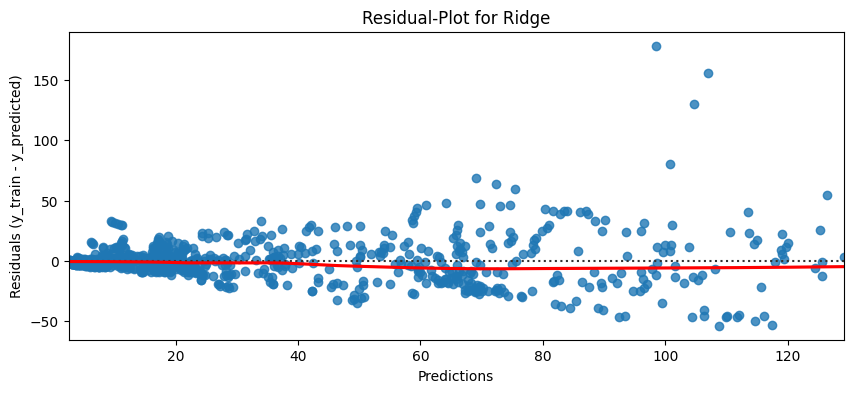

In [285]:
ridge_y_predicts = cross_val_predict(best_ridge_model, X_cl_train, y_train, groups=group_train, cv=gk)
ridge_residuals = y_train - ridge_y_predicts

residual_plot(ridge_y_predicts, ridge_residuals, "Ridge")

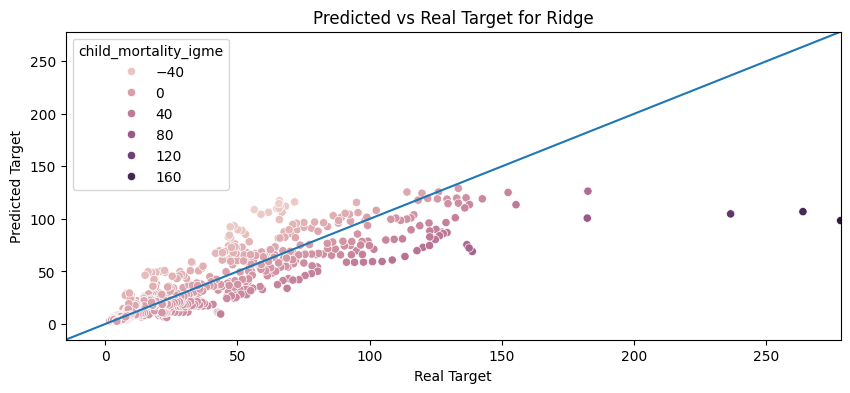

In [287]:
actual_vs_predicted(y_train, ridge_y_predicts, ridge_residuals, "Ridge")

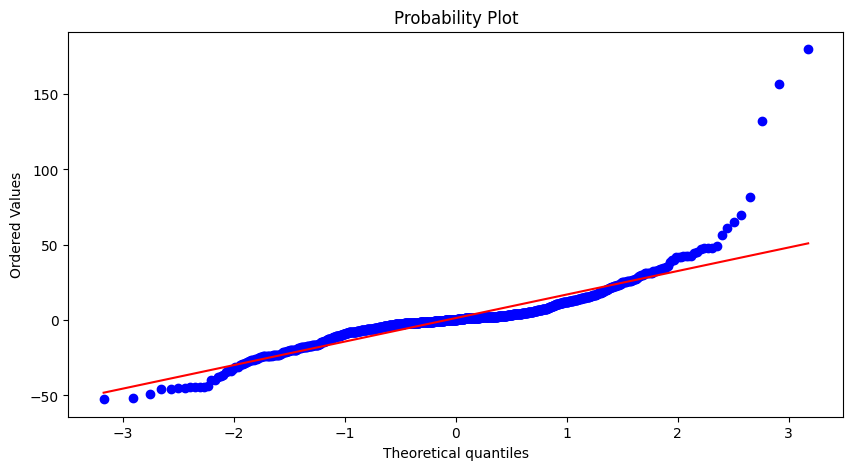

In [288]:
prob_plot(ridge_residuals)

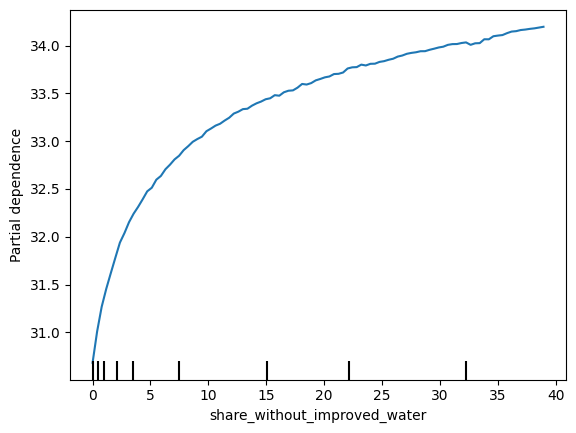

In [289]:
from sklearn.inspection import PartialDependenceDisplay
#prediction decreases when gdp_per_capita increases
#prediction decreases when vaccination_coverage increases
PartialDependenceDisplay.from_estimator(best_ridge_model, X_cl_train, ["share_without_improved_water"])

#### Holdout Testset

In [290]:
ridge_y_pred_holdout = best_ridge_model.predict(X_cl_test)
MAE_test = mean_absolute_error(y_test, ridge_y_pred_holdout)
R2_test  = r2_score(y_test, ridge_y_pred_holdout)
#ridge_test_residuals = y_test - ridge_y_pred_holdout
print(f"----Ridge best model on holdout Testset: Final Metric Scores----\n MAE: {MAE_test}, R2: {R2_test}")

ridge_errors = np.abs(y_test - ridge_y_pred_holdout)
np.percentile(ridge_errors, [50, 75, 90, 95])

----Ridge best model on holdout Testset: Final Metric Scores----
 MAE: 6.1171456745322095, R2: 0.8143551346379547


array([ 2.96941906,  7.54137149, 19.17640763, 24.29816333])

In [291]:
ridge_feature_pipeline = best_ridge_model.regressor_
pre_pipeline_ridge = ridge_feature_pipeline.named_steps['preprocess']
last_transformer_ridge = pre_pipeline_ridge.steps[-1][1]
feature_names_final_ridge = last_transformer_ridge.get_feature_names_out()

In [226]:
pi_result_ridge = permutation_importance(best_ridge_model, X_cl_test, y_test, n_repeats=10, random_state=42)
importance_df_ridge = pd.DataFrame({
    'feature': X_cl_test.columns,
    'importance_mean': np.round(pi_result_ridge.importances_mean, 4),
    'importance_std': np.round(pi_result_ridge.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_ridge

,feature,importance_mean,importance_std
13,kmeans_dist_1,0.2360,0.0431
10,world_regions_wb,0.1942,0.0268
12,kmeans_dist_0,0.1479,0.0305
15,kmeans_dist_3,0.1193,0.0213
7,share_without_improved_water,0.0956,0.0123
16,kmeans_dist_4,0.0813,0.0158
2,gdp_per_capita_worldbank,0.0688,0.0117
17,kmeans_dist_5,0.0647,0.0289
9,years_of_schooling,0.0460,0.0095
1,annual_healthcare_expenditure_per_capita,0.0441,0.0098


### ElasticNet

In [292]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL ELASTICNET
#--------------------------------------------------
elasticnet_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", ElasticNet(max_iter=5000, random_state=99))
])
#Target is rightskewed, logtransform y before training
elasticnet_pipeline_y_log = TransformedTargetRegressor(
    regressor=elasticnet_pipeline,
    #func=np.log1p,
    #inverse_func=np.expm1
    transformer=qu_transformer
)

elasticnet_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10],
    "regressor__model__l1_ratio": [0.1, 0.2, 0.5, 0.8]
}

elasticnet_grid = GridSearchCV(elasticnet_pipeline_y_log, elasticnet_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
elasticnet_grid.fit(X_cl_train, y_train, groups=group_train)
best_elasticnet_model = elasticnet_grid.best_estimator_

show_scores(elasticnet_grid, "ElasticNet")

elasticnet_grid.best_estimator_
#pd.DataFrame(elasticnet_grid.cv_results_)


------ElasticNet CV SCORES--------

R2:

Train Folds R2 Scores: [0.81, 0.81, 0.8, 0.85, 0.81, 0.82, 0.81, 0.78]
            
Mean Train R2 Score: 0.81
            
Test Folds R2 Scores: [0.78, 0.8, 0.78, 0.71, 0.82, 0.62, 0.78, 0.81]
            
Mean Test R2 Score (best_score_): 0.76

MAE:

Train Folds MAE Scores: [8.76, 8.85, 8.61, 8.03, 8.88, 8.89, 8.87, 9.31]
            
Mean Train MAE Score: 8.77
            
Test Folds MAE Scores: [10.34, 8.01, 11.04, 13.67, 9.11, 7.52, 10.65, 9.41]
            
Mean Test MAE Score: 9.97
            
Std Test MAE Score: 1.81

RMSE:

Train Folds RMSE Scores: [15.95, 16.01, 15.95, 12.19, 15.51, 15.91, 15.73, 16.65]
            
Mean Train RMSE Score: 15.49
            
Test Folds RMSE Scores: [14.54, 10.67, 15.34, 30.48, 15.3, 12.54, 16.39, 14.94]
            
Mean Test RMSE Score: 16.28
            
Std Test MAE Score: 5.63
-----------------------------------------



,regressor,Pipeline(step...m_state=99))])
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,steps,"[('prep_nums', ...), ('relative_to_mean', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_nums', ...), ('powertransform_nums', ...), ...]"
,remainder,'passthrough'


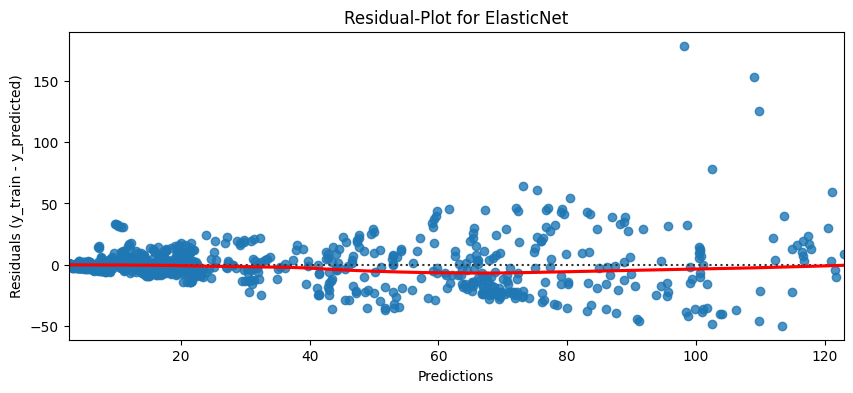

In [293]:
# -------------------------------------------------
# RESIDUAL PLOT FOR ELASTICNET
#--------------------------------------------------
elasticnet_y_predicts = cross_val_predict(best_elasticnet_model, X_cl_train, y_train, groups=group_train, cv=gk)
elasticnet_residuals = y_train - elasticnet_y_predicts

residual_plot(elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

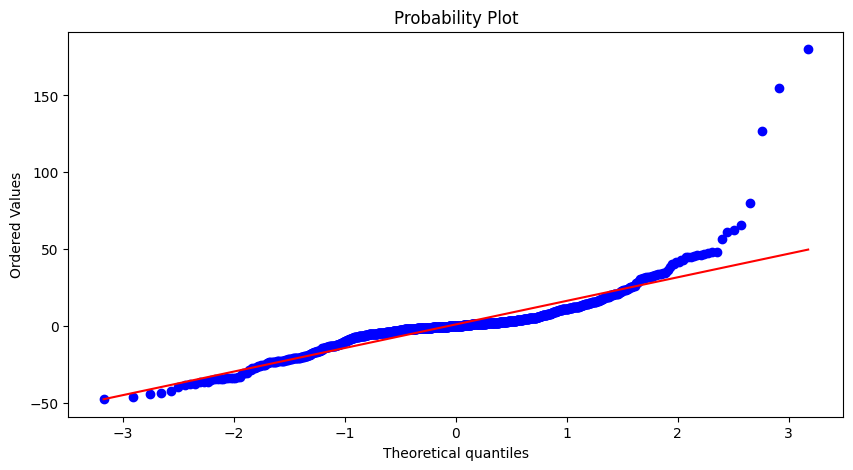

In [294]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR ELASTICNET 
#--------------------------------------------------
prob_plot(elasticnet_residuals)

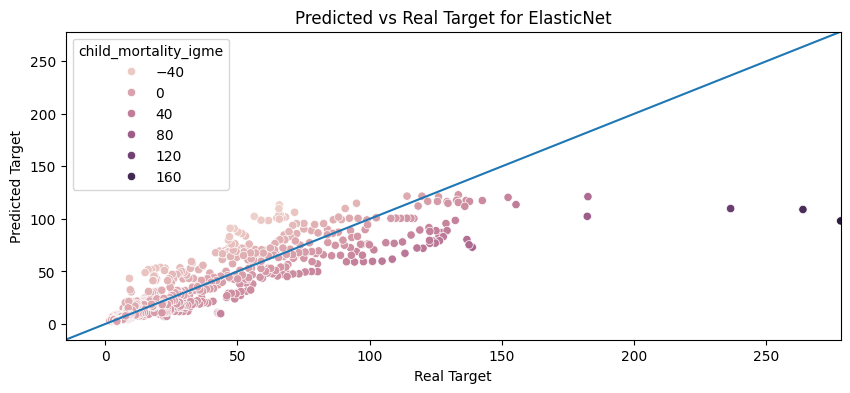

In [295]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR ELASTUCNET
#--------------------------------------------------
#actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")
actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

### Random Forest

In [296]:
# -------------------------------------------------
# RF
#--------------------------------------------------
rf_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", RandomForestRegressor(random_state=99))
])
#Target is rightskewed, logtransform y before training
rf_pipeline_y_log = TransformedTargetRegressor(
    regressor=rf_pipeline,
    #func=np.log1p,
    #inverse_func=np.expm1
    transformer=qu_transformer
)

rf_param_grid = {
    "regressor__model__n_estimators": [300, 500],
    "regressor__model__max_depth": [1, 3],
    "regressor__model__min_samples_split": [5, 15],
    "regressor__model__min_samples_leaf": [20, 30],
    "regressor__model__max_features": [0.2],
    "regressor__model__max_samples": [0.7, 0.8]
}

rf_grid = GridSearchCV(rf_pipeline_y_log, rf_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
rf_grid.fit(X_cl_train, y_train, groups=group_train)
best_rf_model = rf_grid.best_estimator_

show_scores(rf_grid, "RF")
rf_grid.best_estimator_


------RF CV SCORES--------

R2:

Train Folds R2 Scores: [0.81, 0.81, 0.81, 0.83, 0.79, 0.81, 0.81, 0.81]
            
Mean Train R2 Score: 0.81
            
Test Folds R2 Scores: [0.67, 0.87, 0.72, 0.59, 0.78, 0.67, 0.74, 0.67]
            
Mean Test R2 Score (best_score_): 0.71

MAE:

Train Folds MAE Scores: [8.2, 8.89, 8.11, 8.0, 8.96, 8.73, 8.47, 8.46]
            
Mean Train MAE Score: 8.48
            
Test Folds MAE Scores: [12.11, 6.34, 11.83, 17.62, 9.25, 8.59, 11.52, 12.36]
            
Mean Test MAE Score: 11.2
            
Std Test MAE Score: 3.13

RMSE:

Train Folds RMSE Scores: [15.61, 16.26, 15.71, 12.89, 16.43, 16.26, 15.67, 15.8]
            
Mean Train RMSE Score: 15.58
            
Test Folds RMSE Scores: [17.81, 8.74, 17.22, 36.17, 17.18, 11.74, 17.69, 19.64]
            
Mean Test RMSE Score: 18.27
            
Std Test MAE Score: 7.57
-----------------------------------------



,regressor,Pipeline(step...m_state=99))])
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,steps,"[('prep_nums', ...), ('relative_to_mean', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_nums', ...), ('powertransform_nums', ...), ...]"
,remainder,'passthrough'


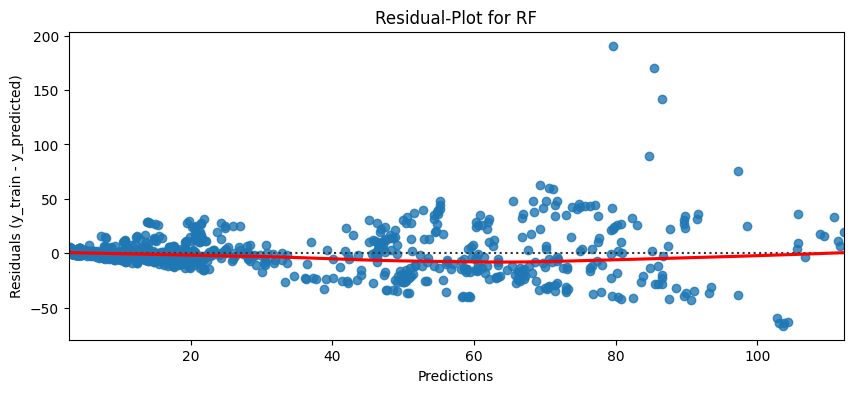

In [297]:
rf_y_predicts = cross_val_predict(best_rf_model, X_cl_train, y_train, groups=group_train, cv=gk)
rf_residuals = y_train - rf_y_predicts

residual_plot(rf_y_predicts, rf_residuals, "RF")

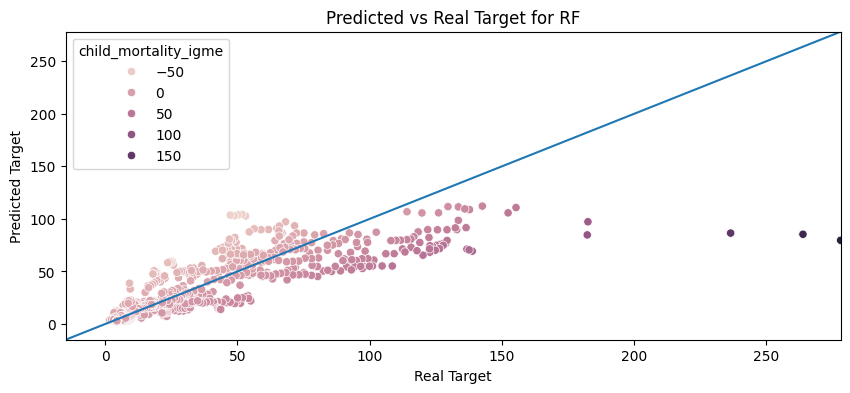

In [298]:
actual_vs_predicted(y_train, rf_y_predicts, rf_residuals, "RF")

In [299]:
rf_feature_pipeline = best_rf_model.regressor_
pre_pipeline = rf_feature_pipeline.named_steps['preprocess']
last_transformer = pre_pipeline.steps[-1][1]
feature_names_final = last_transformer.get_feature_names_out()
last_transformer
print("Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:")
print(feature_names_final)

Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:
['annual_healthcare_expenditure_per_capita' 'gdp_per_capita_worldbank'
 'nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries'
 'world_income_group_missing' 'kmeans_dist_0' 'kmeans_dist_1'
 'kmeans_dist_2' 'kmeans_dist_3' 'kmeans_dist_4' '

### XGBoost

In [246]:
# -------------------------------------------------
# XGBOOST
#--------------------------------------------------
xgb_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", XGBRegressor(objective="reg:absoluteerror", n_jobs=-1, random_state=42))
])
#Target is rightskewed, logtransform y before training
xgb_pipeline_y_log = TransformedTargetRegressor(
    regressor=xgb_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

xgb_param_grid = {
    "regressor__model__n_estimators": [200, 400],
    "regressor__model__learning_rate": [0.01, 0.03],
    "regressor__model__max_depth": [3],
    "regressor__model__min_child_weight": [10],
    "regressor__model__subsample": [0.7],  
    "regressor__model__reg_alpha": [0.1],
     "regressor__model__reg_lambda": [5],
}

xgb_search = GridSearchCV(xgb_pipeline_y_log, xgb_param_grid, cv=gk, scoring=metrics, refit="mae", n_jobs=-1, return_train_score=True)

xgb_search.fit(X_cl_train, y_train, groups=group_train)

show_scores(xgb_search, "XGB")

best_xgb_model = xgb_search.best_estimator_
best_xgb_model


------XGB CV SCORES--------

R2:

Train Folds R2 Scores: [0.94, 0.96, 0.95, 0.99, 0.95, 0.96, 0.96, 0.96]
            
Mean Train R2 Score: 0.96
            
Test Folds R2 Scores: [0.77, 0.77, 0.76, 0.6, 0.82, 0.66, 0.87, 0.73]
            
Mean Test R2 Score (best_score_): 0.75

MAE:

Train Folds MAE Scores: [1.71, 1.5, 1.66, 1.09, 1.51, 1.32, 1.55, 1.54]
            
Mean Train MAE Score: 1.48
            
Test Folds MAE Scores: [9.64, 7.68, 11.61, 16.53, 8.95, 7.53, 8.19, 10.93]
            
Mean Test MAE Score: 10.13
            
Std Test MAE Score: 2.78

RMSE:

Train Folds RMSE Scores: [8.69, 7.32, 8.38, 3.11, 7.67, 7.24, 6.73, 7.23]
            
Mean Train RMSE Score: 7.05
            
Test Folds RMSE Scores: [15.12, 11.47, 15.9, 35.72, 15.46, 11.87, 12.72, 17.8]
            
Mean Test RMSE Score: 17.01
            
Std Test MAE Score: 7.36
-----------------------------------------



,regressor,"Pipeline(step...=None, ...))])"
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,steps,"[('prep_nums', ...), ('relative_to_mean', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_nums', ...), ('powertransform_nums', ...), ...]"
,remainder,'passthrough'


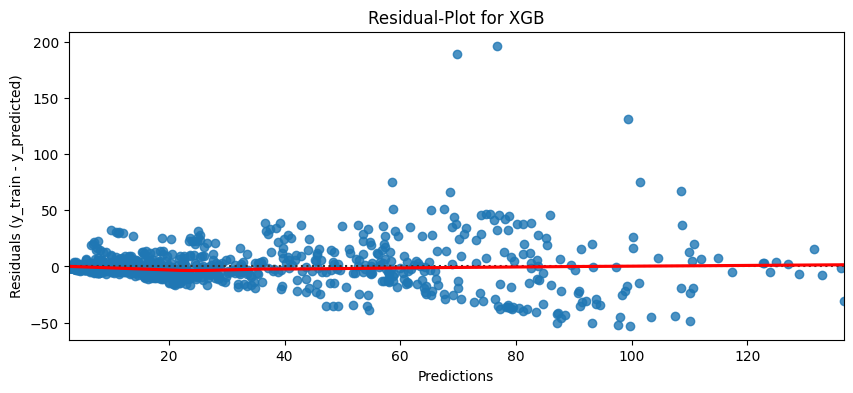

In [247]:
xgb_y_predicts = cross_val_predict(best_xgb_model, X_cl_train, y_train, groups=group_train, cv=gk)
xgb_residuals = y_train - xgb_y_predicts

residual_plot(xgb_y_predicts, xgb_residuals, "XGB")

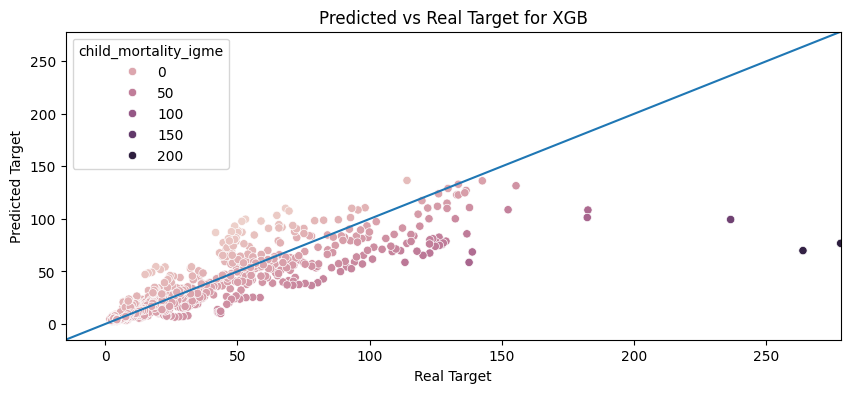

In [248]:
actual_vs_predicted(y_train, xgb_y_predicts, xgb_residuals, "XGB")

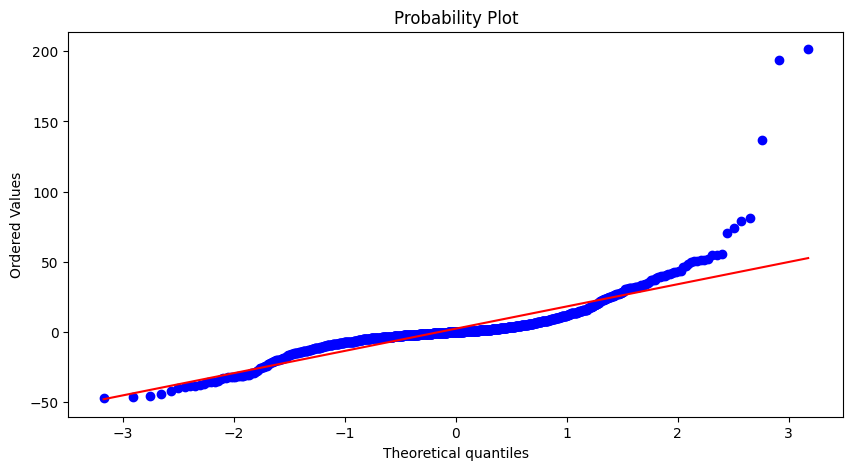

In [249]:
prob_plot(xgb_residuals)

In [250]:
xgb_y_pred_holdout = best_xgb_model.predict(X_cl_test)
MAE_test_xgb = mean_absolute_error(y_test, xgb_y_pred_holdout)
R2_test_xgb  = r2_score(y_test, xgb_y_pred_holdout)
print(f"----XGB best model on holdout Testset: Final Metric Scores----\n MAE: {MAE_test_xgb}, R2: {R2_test_xgb}")

xgb_errors = np.abs(y_test - xgb_y_pred_holdout)
np.percentile(xgb_errors, [50, 75, 90, 95])

----XGB best model on holdout Testset: Final Metric Scores----
 MAE: 5.557470426887134, R2: 0.839386166806831


array([ 2.55532258,  8.31465198, 14.19541761, 18.92526996])

### Extremes (Quantile)

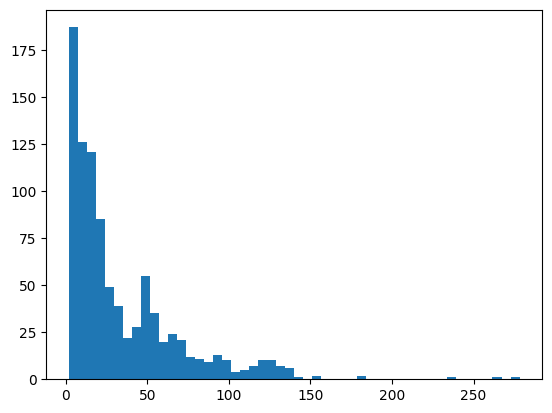

In [517]:
plt.hist(y_train, bins=50)
plt.show()

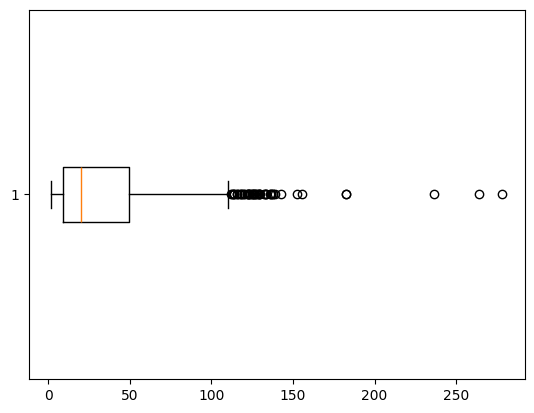

In [518]:
plt.boxplot(y_train, vert=False)
plt.show()

In [42]:
for q in [0.5, 0.70, 0.95]:
    print(f"{q*100:.0f}% Quant:", np.quantile(y_train, q))

qu = 0.95
threshold = np.quantile(y_train, qu)
n_extreme = (y_train > threshold).sum()
print("\nExtremes num:", n_extreme)

50% Quant: 20.0529625
70% Quant: 44.26989699999999
95% Quant: 113.22383799999992

Extremes num: 47


In [579]:
q50 = np.quantile(y_train, 0.5)
print("50%-Quantil (Median):", q50)

50%-Quantil (Median): 20.0529625


In [580]:
n_above_q50 = (y_train > q50).sum()
n_below_q50 = (y_train <= q50).sum()
print("Anzahl über q50:", n_above_q50)
print("Anzahl unter q50:", n_below_q50)

Anzahl über q50: 462
Anzahl unter q50: 462


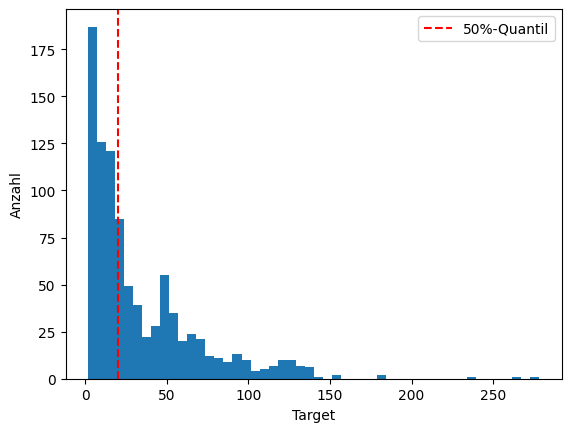

In [581]:
plt.hist(y_train, bins=50)
plt.axvline(q50, color='red', linestyle='--', label='50%-Quantil')
plt.xlabel("Target")
plt.ylabel("Anzahl")
plt.legend()
plt.show()

### Quantile Regression with GradientBoostingRegressor

In [171]:
# -------------------------------------------------
# GradientBoostingRegressor
#--------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, make_scorer

def pinball_score(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

quantiles = [0.5, 0.75]
models = {}

gb_param_grid = {
    "regressor__model__n_estimators": [200, 400],
    "regressor__model__max_depth": [2, 3],
    "regressor__model__learning_rate": [0.05, 0.1]
}

for q in quantiles:
    print(f"Train for {q}")
    
    gb_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", GradientBoostingRegressor(loss="quantile",alpha=q,random_state=99))
    ])

    gb_pipeline_y_log  = TransformedTargetRegressor(
        regressor=gb_pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # fit trainset via GridSearchCV
    gb_grid = GridSearchCV(gb_pipeline_y_log, gb_param_grid, cv=gk, scoring=pinball_score(q), return_train_score=True, n_jobs=-1)
    gb_grid.fit(X_cl_train, y_train, groups=group_train)

    models[q] = gb_grid.best_estimator_
    print("Best params:", gb_grid.best_params_)
    #gb_results = pd.DataFrame(gb_grid.cv_results_)
    #print(gb_results[["params", "mean_test_score", "rank_test_score"]])
    

#show_scores(gb_grid, "GradientBoostingRegressor")   
#best_ridge_model = ridge_grid.best_estimator_
# print metrics scores
#ridge_grid.best_estimator_

Train for 0.5
Best params: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 3, 'regressor__model__n_estimators': 200}
Train for 0.75
Best params: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 200}


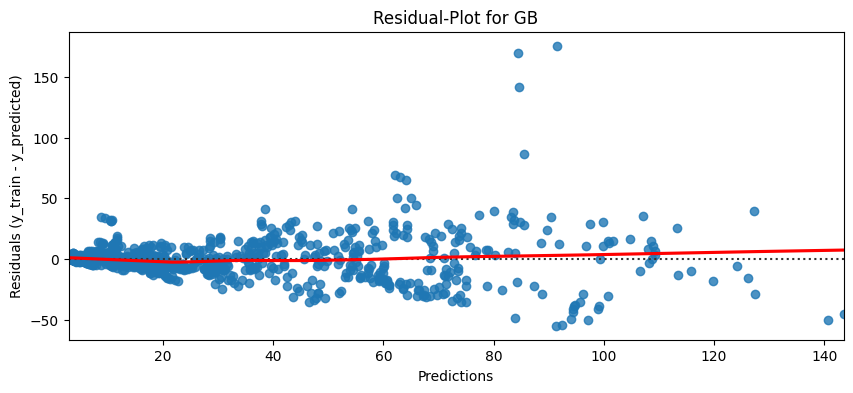

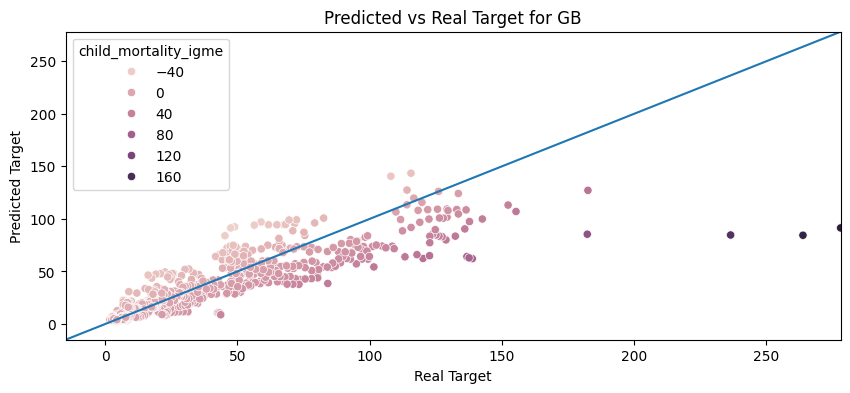

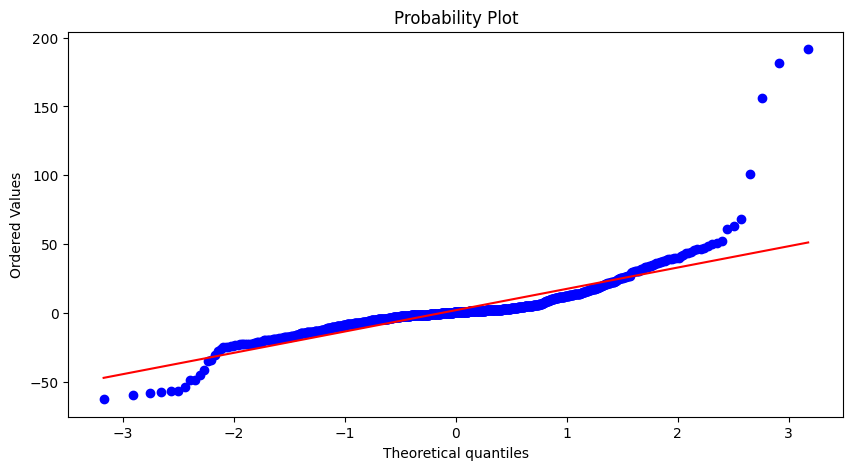

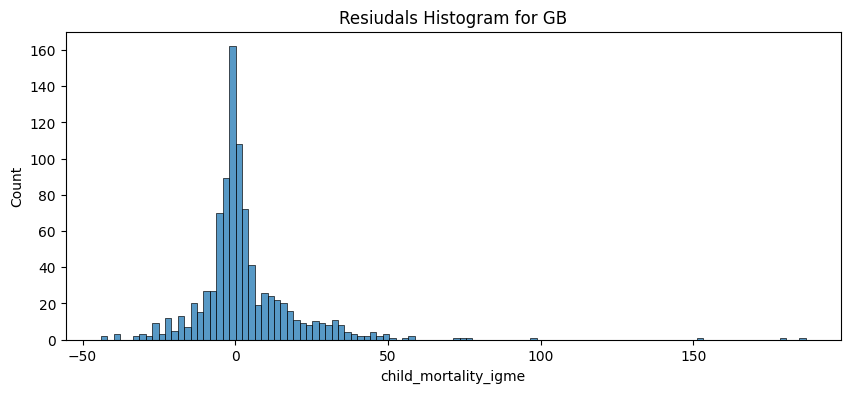

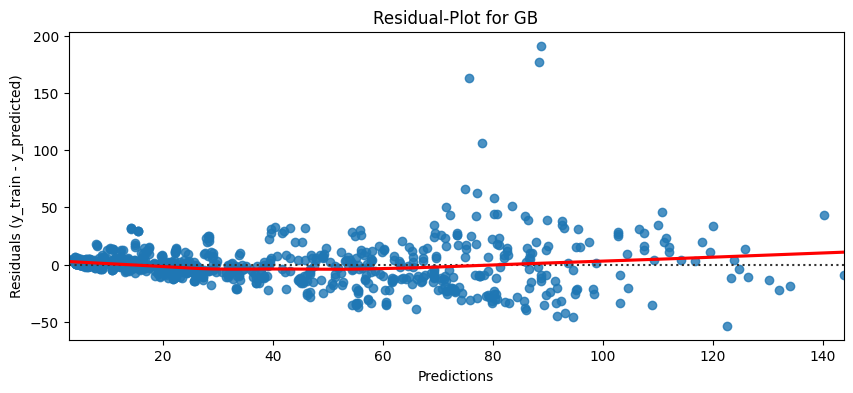

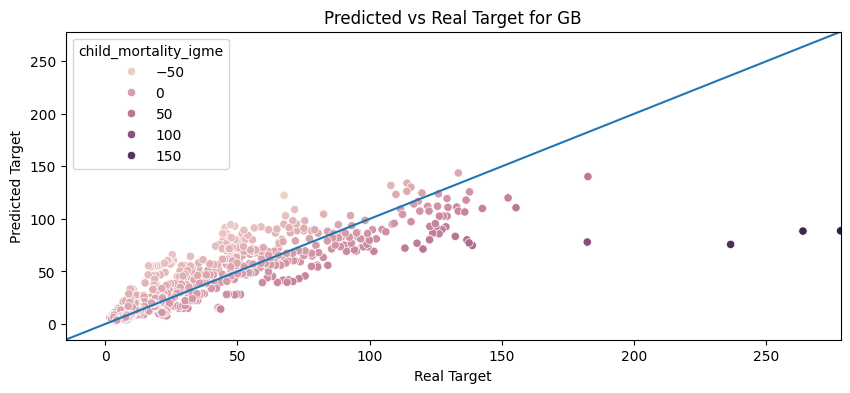

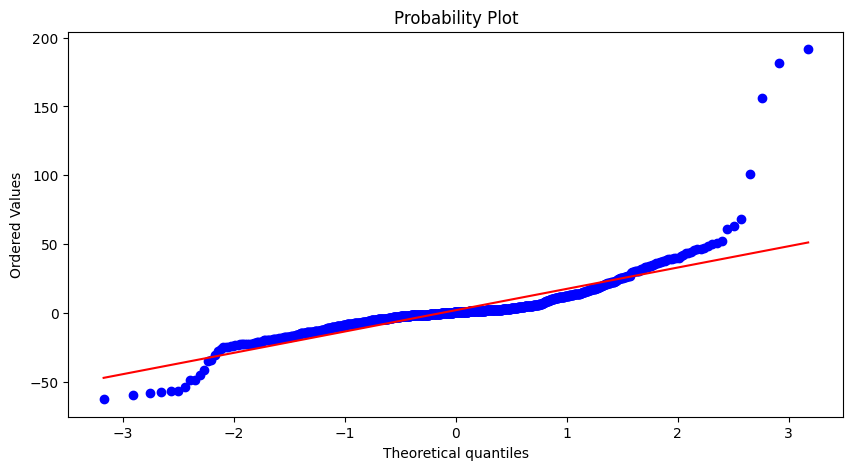

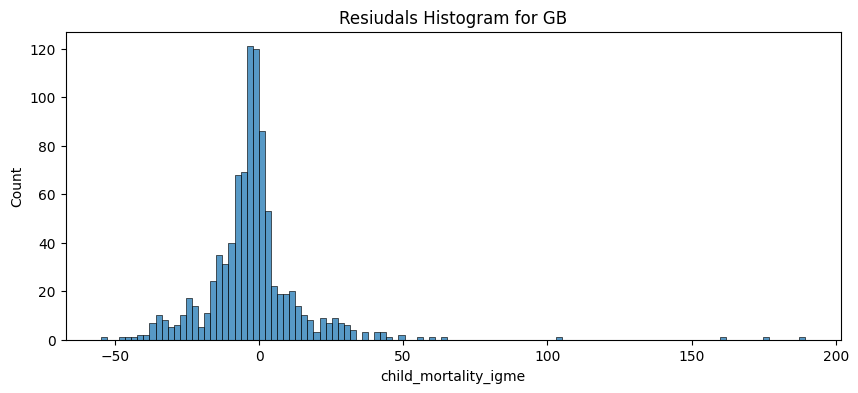

In [172]:
for q, model in models.items():
    y_predicts_gb = cross_val_predict(model, X_cl_train, y_train, groups=group_train, cv=gk) 
    gb_residuals = y_train - y_predicts_gb

    residual_plot(y_predicts_gb, gb_residuals, "GB")
    actual_vs_predicted(y_train, y_predicts_gb, gb_residuals, "GB")
    prob_plot(lr_residuals)
    residuals_hist(gb_residuals, "GB")

#xgb_y_predicts = cross_val_predict(best_xgb_model, X_cl_train, y_train, groups=group_train, cv=gk)
#xgb_residuals = y_train - xgb_y_predicts

In [173]:
gb_y_pred_test = {}
for q, model in models.items():
    gb_y_pred_test[q] = model.predict(X_cl_test)

In [174]:
for q in quantiles:
    loss = mean_pinball_loss(y_test, gb_y_pred_test[q], alpha=q)
    print(f"Quantile {q}, Pinball Loss: {loss:.4f}")

Quantile 0.5, Pinball Loss: 2.8395
Quantile 0.75, Pinball Loss: 2.0904


In [175]:
gb_y_pred_median = gb_y_pred_test[0.5]
mae = mean_absolute_error(y_test, gb_y_pred_median)
rmse = np.sqrt(mean_squared_error(y_test, gb_y_pred_median))
print(f"Median Q0.5: MAE={mae:.2f}, RMSE={rmse:.2f}")

Median Q0.5: MAE=5.68, RMSE=9.36


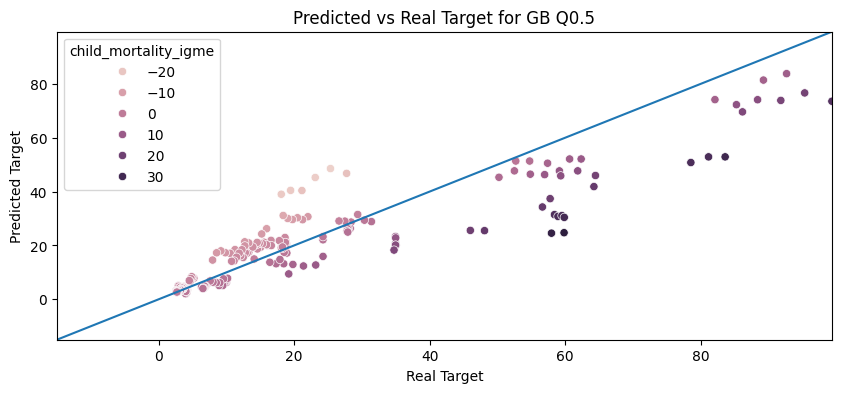

In [176]:
actual_vs_predicted(y_test, gb_y_pred_test[0.5], y_test - gb_y_pred_test[0.5], "GB Q0.5")

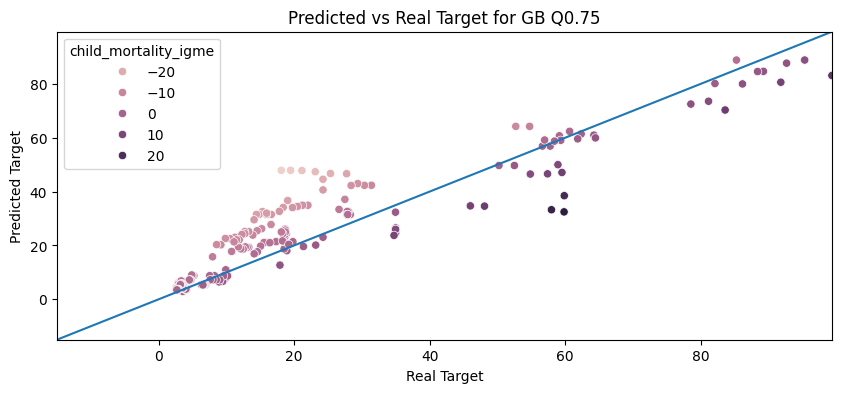

In [177]:
actual_vs_predicted(y_test, gb_y_pred_test[0.75], y_test - gb_y_pred_test[0.75], "GB Q0.75")

### Quantile Regression with QuantileRegressor

In [307]:
# -------------------------------------------------
# QuantileRegressor
#--------------------------------------------------
#https://xgboosting.com/xgboost-prediction-interval-using-quantile-regression/
from sklearn.linear_model import QuantileRegressor

qr_quantiles = [0.25, 0.5, 0.75, 0.95]
qr_models = {}
cv_results = {}

def pinball_scoring(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

qr_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 0.5, 1]
}

for q in qr_quantiles:
    print(f"Train for {q}")
    
    qr_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", QuantileRegressor(quantile=q))
    ])

    qr_pipeline_y_log = TransformedTargetRegressor(
        regressor=qr_pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # fit trainset via GridSearchCV
    qr_grid = GridSearchCV(qr_pipeline_y_log, qr_param_grid, cv=gk, scoring=pinball_scoring(q), return_train_score=True, n_jobs=-1)
    qr_grid.fit(X_train, y_train, groups=group_train)

    qr_models[q] = qr_grid.best_estimator_
    print("Best params:", qr_grid.best_params_)
    #gb_results = pd.DataFrame(gb_grid.cv_results_)
    #print(gb_results[["params", "mean_test_score", "rank_test_score"]])

Train for 0.25
Best params: {'regressor__model__alpha': 0.01}
Train for 0.5
Best params: {'regressor__model__alpha': 0.01}
Train for 0.75
Best params: {'regressor__model__alpha': 0.01}
Train for 0.95
Best params: {'regressor__model__alpha': 0.01}


Coverage: 0.25757575757575757
Above diagonal: 0.7424242424242424
Below diagonal: 0.25757575757575757

Trainset: Quantile 0.25, Pinball Loss: 3.4266

Coverage: 0.48484848484848486
Above diagonal: 0.5151515151515151
Below diagonal: 0.48484848484848486

Trainset: Quantile 0.5, Pinball Loss: 5.2365

Coverage: 0.7175324675324676
Above diagonal: 0.2824675324675325
Below diagonal: 0.7175324675324676

Trainset: Quantile 0.75, Pinball Loss: 4.6437

Coverage: 0.9231601731601732
Above diagonal: 0.07683982683982683
Below diagonal: 0.9231601731601732

Trainset: Quantile 0.95, Pinball Loss: 2.5463



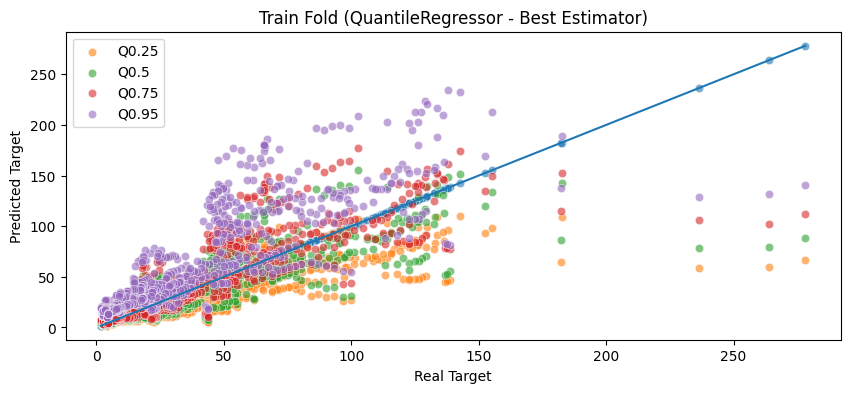

In [337]:
qr_y_pred_train = {}
qr_residuals = {}
for q, model in qr_models.items():
    qr_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    qr_residuals[q] = y_train - qr_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= qr_y_pred_train[q]))
    print("Above diagonal:", np.mean(y_train > qr_y_pred_train[q]))
    print("Below diagonal:", np.mean(y_train < qr_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, qr_y_pred_train[q], alpha=q)
    print(f"\nTrainset: Quantile {q}, Pinball Loss: {loss:.4f}\n")
    

plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_train, y=qr_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Train Fold (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

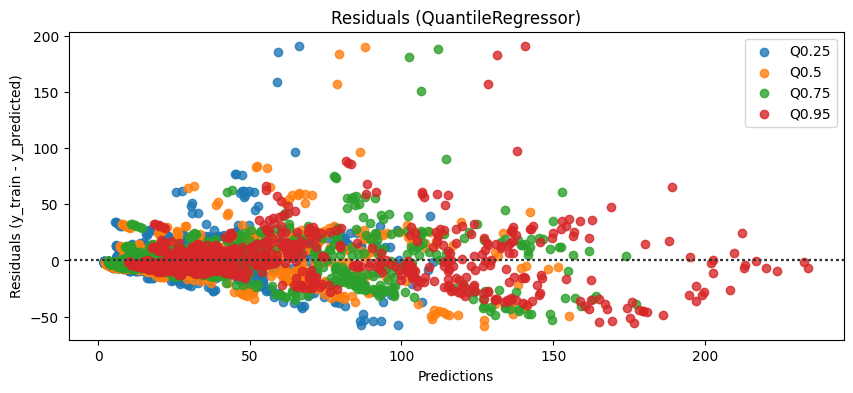

In [309]:
plt.figure(figsize=(10,4))
for q in qr_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=qr_y_pred_train[q], y=qr_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (QuantileRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

In [310]:
qr_results = pd.DataFrame(qr_grid.cv_results_)
qr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
0,0.284582,0.011871,0.052284,0.004828,0.01,{'regressor__model__alpha': 0.01},-3.331214,-1.193049,-1.936210,-6.748095,-1.149187,-2.313393,-1.857406,-1.871524,-2.550010,1.710651,1,-1.985582,-1.935578,-1.855512,-1.265852,-1.933449,-1.617851,-1.802073,-1.901745,-1.787205,0.223956
1,0.265055,0.026669,0.070184,0.020509,0.10,{'regressor__model__alpha': 0.1},-4.364884,-4.524938,-4.144224,-11.881842,-5.700061,-4.644444,-5.364082,-4.530442,-5.644364,2.407516,2,-5.357601,-5.351367,-5.398828,-4.451347,-5.178376,-5.328426,-5.209619,-5.326946,-5.200314,0.291747
2,0.248652,0.020652,0.058063,0.012265,0.50,{'regressor__model__alpha': 0.5},-4.364884,-4.524938,-4.144224,-11.881842,-5.700061,-4.644444,-5.364082,-4.530442,-5.644364,2.407516,2,-5.357601,-5.351367,-5.398828,-4.451347,-5.178376,-5.328426,-5.209619,-5.326946,-5.200314,0.291747
3,0.272959,0.051334,0.065988,0.010350,1.00,{'regressor__model__alpha': 1},-4.364884,-4.524938,-4.144224,-11.881842,-5.700061,-4.644444,-5.364082,-4.530442,-5.644364,2.407516,2,-5.357601,-5.351367,-5.398828,-4.451347,-5.178376,-5.328426,-5.209619,-5.326946,-5.200314,0.291747


#### Holdout Testset

In [324]:
qr_y_pred_test = {}
qr_test_residuals = {}
for q, model in qr_models.items():
    qr_y_pred_test[q] = model.predict(X_test)

    qr_test_residuals[q] = y_test - qr_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= qr_y_pred_test[q]))
    print("Above diagonal:", np.mean(y_test > qr_y_pred_test[q]))
    print("Below diagonal:", np.mean(y_test < qr_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, qr_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, qr_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.2777777777777778
Above diagonal: 0.7222222222222222
Below diagonal: 0.2777777777777778

Quantile 0.25, Pinball Loss: 1.9853

Coverage: 0.5299145299145299
Above diagonal: 0.4700854700854701
Below diagonal: 0.5299145299145299

Quantile 0.5, Pinball Loss: 2.5706

Coverage: 0.7991452991452992
Above diagonal: 0.20085470085470086
Below diagonal: 0.7991452991452992

Quantile 0.75, Pinball Loss: 1.9909

Coverage: 0.9658119658119658
Above diagonal: 0.03418803418803419
Below diagonal: 0.9658119658119658

Quantile 0.95, Pinball Loss: 1.0116


Q0.5 MAE: 5.141232722348246


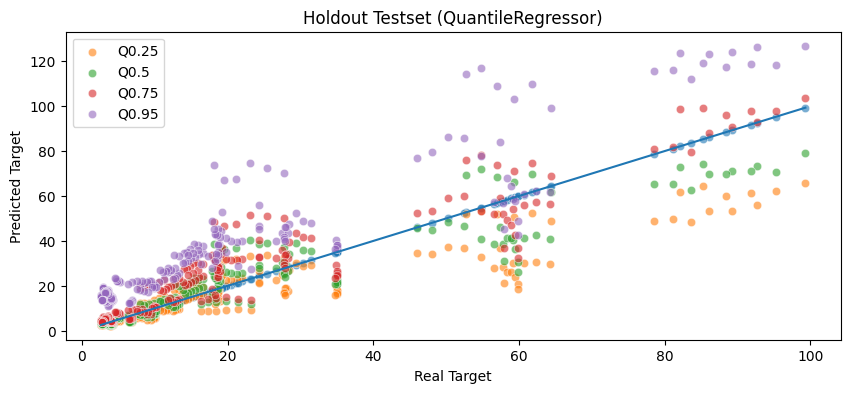

In [312]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_test, y=qr_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (QuantileRegressor)")
plt.legend()
plt.show()

In [317]:
pi_result_qr = permutation_importance(qr_models[0.5], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr.importances_mean, 4),
    'importance_std': np.round(pi_result_qr.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr

,feature,importance_mean,importance_std
1,annual_healthcare_expenditure_per_capita,0.4980,0.0595
10,world_regions_wb,0.1748,0.0255
7,share_without_improved_water,0.1203,0.0158
8,vaccination_coverage_who_unicef,0.0872,0.0137
9,years_of_schooling,0.0384,0.0060
11,world_income_group,0.0353,0.0084
2,gdp_per_capita_worldbank,0.0125,0.0024
3,nurses_and_midwives_per_1000_people,0.0120,0.0036
5,prevalence_of_undernourishment,0.0017,0.0025
0,Entity,0.0000,0.0000
